<a href="https://colab.research.google.com/github/torrhen/pytorch/blob/main/02_pytorch_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import third party utility functions

In [ ]:
# import third party function using requests HTTP library
import requests
from pathlib import Path # file management library

if Path('helper_functions.py').is_file(): # true if a valid file exists
  # no need to download, already exists
  pass
else:
  # download file using HTTP
  # send a GET resquest to a webpage
  response = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')

  # write to a binary file f (wb) or create the file if it does not yet exist
  with open('helper_functions.py', 'wb') as f:
    f.write(response.content) # write the content of the webpage to f
  # close file once finished


In [ ]:
def calc_accuracy(y_preds, y_true):
  # torch.eq calculates the element wise equality of two tensors
  num_correct = torch.eq(y_preds, y_true).sum().item() # sum is used to calculate the number of predictions that match true value, .item() converts rank 1 tensor to scalar
  return (num_correct / len(y_true)) * 100

Set up device agnostic code

In [ ]:
import torch
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Create first circle data set

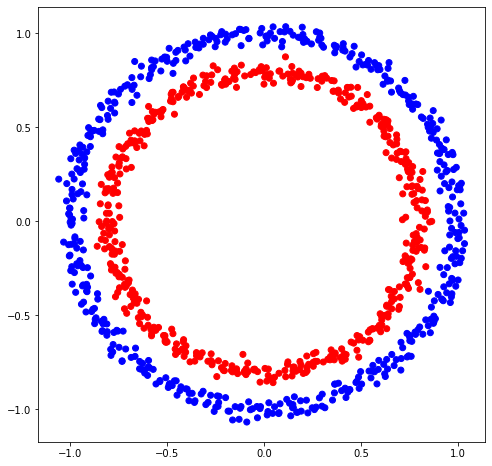

In [ ]:
# create circle toy dataset
from sklearn.datasets import make_circles

n = 1000 # num of samples
X, y = make_circles(1000, noise=0.03, random_state=42) # load dataset

# visualize dataset
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr)

In [ ]:
import torch

# convert to tensors from numpy array
X = torch.from_numpy(X).type(torch.float32) # shape [1000, 2]
y = torch.from_numpy(y).type(torch.float32) # change from shape [1000] to shape [1000, 1]

In [ ]:
# training and test split
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
# confirm shape of data
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

torch.Size([800, 2])
torch.Size([800])
torch.Size([200, 2])
torch.Size([200])


In [ ]:
# allocate data to device
train_X = train_X.to(device)
train_y = train_y.to(device)
test_X = test_X.to(device)
test_y = test_y.to(device)

## Build simple linear model (no non-linear activation)

In [ ]:
from torch import nn

# build model
class BinaryClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=32)
    self.linear2 = nn.Linear(in_features=32, out_features=1)

    # self.linear3 = nn.Linear(in_features=5, out_features=5)
    # self.linear4 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    x = self.linear1(x)
    x = self.linear2(x)
    return x
    # return self.linear4(self.linear3(self.linear2(self.linear1(x))))



In [ ]:
model = BinaryClassifier()
model = model.to(device)
print(model.state_dict())

OrderedDict([('linear1.weight', tensor([[ 0.7001, -0.5128],
        [ 0.3636, -0.5948],
        [-0.1412, -0.2828],
        [-0.2539, -0.2840],
        [-0.6828,  0.0706],
        [ 0.1230, -0.3708],
        [ 0.2694, -0.1912],
        [-0.1064, -0.4097],
        [-0.3702,  0.4652],
        [-0.0765,  0.6496],
        [ 0.2234, -0.5393],
        [-0.6547,  0.5419],
        [ 0.6259, -0.3737],
        [-0.4614, -0.3558],
        [ 0.0483,  0.1197],
        [-0.0497, -0.1897],
        [-0.3264, -0.3512],
        [-0.5883,  0.4243],
        [-0.2625,  0.1455],
        [ 0.4335, -0.2175],
        [-0.4789,  0.3004],
        [ 0.4356, -0.6610],
        [ 0.6961,  0.5089],
        [ 0.1172, -0.5292],
        [-0.4802,  0.2896],
        [-0.5788, -0.3113],
        [ 0.4150, -0.2737],
        [ 0.1616, -0.6450],
        [ 0.1115,  0.2304],
        [-0.0923,  0.6665],
        [ 0.1923,  0.1580],
        [ 0.3686, -0.0524]], device='cuda:0')), ('linear1.bias', tensor([-0.4267, -0.4654,  0.0162, 

Set up loss function and gradient descent optimizer

In [ ]:
from torch import nn
import torch
# pick loss function
# loss_func = nn.BCELoss() # inputs to the loss function are required to have been fed into sigmoid function first before the loss function
loss_func = nn.BCEWithLogitsLoss() # logits are values (-inf, +inf) that are inputs to a softmax layer, ** sigmoid activation built-in **, great numerically stability than manually combining BCELoss and sigmoid

# pick optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

## Train and test simple linear model (no non-linear activation)

In [ ]:
epochs = 1000

for epoch in range(epochs):
  model.train()

  # 1. forward pass
  y_logits = model(train_X) # logits
  y_pred = torch.round(torch.sigmoid(y_logits)) # predicted label

  # 2. calculate loss
  loss = loss_func(y_logits, train_y) # logits passed to BCELossWithLogits, sigmoid applied as part of function
  # calculate accuracy
  acc = calc_accuracy(y_pred, train_y)

  # 3 zero grad
  optimizer.zero_grad()

  # 4. backpropagation
  loss.backward()

  # 5. gradient update
  optimizer.step()

  # evaluate model on test set
  model.eval() # set model evaluation options
  with torch.inference_mode(): # turn off gradient tracking
    y_logits_test = model(test_X) # logits
    y_pred_test = torch.round(torch.sigmoid(y_logits_test)) # predicted label

    test_loss = loss_func(y_logits_test, test_y) # logits passed to BCELossWithLogits, sigmoid applied as part of function
    test_acc = calc_accuracy(y_pred_test, test_y)
    
    print(f"train loss {loss:.5f} | train accuracy {acc:.2f}% | test loss {test_loss:.5f} | test accuracy {test_acc:.2f}%")

ValueError: ignored

In [ ]:
import matplotlib.pyplot as plt
from helper_functions import plot_decision_boundary # import function from file downloaded above

# 1 row, 2 column subplots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # select the index of the first subplot
plt.title('training set')
plot_decision_boundary(model, train_X, train_y) # plot boundary
plt.subplot(1, 2, 2) # select the index of the second subplot
plt.title('test set')
plot_decision_boundary(model, test_X, test_y) # plot boundary
plt.show()

# Linear model struggles to fit the non-linear data. Non-linear activation layers are required

Ways to improve model:


*   Adding more layers (deeper network)
*   Adding more hidden units
*   More training epochs
*   Adding/modifying activations between layers
*   Updating the optimizer
*   Updating the learning rate for gradient descent







## Build a second network using non-linear ReLU activation layers

In [ ]:
class NonLinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))


In [ ]:
non_linear_model = NonLinearModel()
print(non_linear_model.state_dict())

# allocate model to chosen device
non_linear_model = non_linear_model.to(device)

In [ ]:
# pick optimizer
optimizer = torch.optim.SGD(params=non_linear_model.parameters(), lr=0.2) # rewrite optimizer to track the new model parameters

In [ ]:
# training and evalute model

epochs = 1000

for epoch in range(epochs):
  non_linear_model.train()

  # forward pass
  y_logits = non_linear_model(train_X)
  y_pred = torch.round(torch.sigmoid(y_logits))
  acc = calc_accuracy(y_pred, train_y)

  # calculate the loss
  loss = loss_func(y_logits, train_y)

  # zero grad
  optimizer.zero_grad()

  # back propagation
  loss.backward()

  # gradient descent
  optimizer.step()

  non_linear_model.eval()
  with torch.inference_mode():
    y_logits_test = non_linear_model(test_X)
    y_labels_test = torch.round(torch.sigmoid(y_logits_test))

    test_loss = loss_func(y_logits_test, test_y)
    test_acc = calc_accuracy(y_labels_test, test_y)
    print(f"loss: {loss:.5f} | acc: {acc:.2f}% | test loss: {test_loss:.5f} | test acc: {test_acc:.2f}%")

## Using non-linear activation layers as part of the new model allows us to model non-linear data.

In [ ]:
# 1 row, 2 column subplots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # select the index of the first subplot
plt.title('training set')
plot_decision_boundary(non_linear_model, train_X, train_y) # plot boundary
plt.subplot(1, 2, 2) # select the index of the second subplot
plt.title('test set')
plot_decision_boundary(non_linear_model, test_X, test_y) # plot boundary
plt.show()

In [ ]:
a = torch.arange(-10, 10, 1.0, dtype=torch.float32)
print(a)

def custom_relu(x: torch.Tensor) -> torch.Tensor: # type hinting
  return torch.max(torch.tensor(0), x)

def custom_sigmoid(x: torch.Tensor) -> torch.Tensor: # type hinting
  denom = 1 + torch.exp(-x)
  return 1 / denom

In [ ]:
rel = custom_relu(a)
plt.plot(rel)


In [ ]:
sig = custom_sigmoid(a)
plt.plot(sig)

## Additional performance metrics...

found within torchmetrics module of PyTorch

* Accuracy - how many points are correctly classified out of the entire dataset (balanced classes)
* Precision
* Recall
* F1-score
* Confusion Matrix
* Classification Report

Customer metric classes can be created by subclassing the Metrics base class from PyTorch

**TORCH METRICS MUST BE ALLOCATED TO THE SAME DEVICE AS MODEL AND DATA** Done using the .to() method